# Electrostatic potential minimization

The main purpose of `iwopy` is to be helpful when attacking more complicated optimization tasks than the minimization of simple analytical functions. As an example, we consider the minimization of an inverse distance type potential for a fully coupled system of $N$ particles in two dimensions. We can imagine such a system to be composed of $N$ individual point charges, each of them carrying the same electric unit charge. The potential that we want to minimize is then represented by
$$
V = \sum_{i\neq j} \frac 1 {|\mathrm r_i - \mathrm r_j|} \ , \quad \text{where} \quad \mathrm r_i = \left( \begin{array}{c} x_i \\ y_i \end{array} \right)
$$
denotes the two dimensional position vector of charge $i$ and the sum is over all unequal index pairs. This potential favours large distances between charges, hence we need to constrain them to a certain area for a meaningful solution. We confine them to a circle of radius $R$ by imposing $N$ constraints,
$$
|\mathrm r_i| \leq R \ , \quad \text{for all} \quad i = 0 \ldots N-1 \ .
$$
These are the required imports for this example:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iwopy import Problem, Objective, Constraint
from iwopy.interfaces.pymoo import Optimizer_pymoo

We start by creating a specific class that describes the variables of our problem:

In [2]:
class ChargesProblem(Problem):
    def __init__(self, xy_init, radius):
        super().__init__(name="charges_problem")
        self.xy_init = xy_init
        self.n_charges = len(xy_init)
        self.radius = radius

    def var_names_float(self):
        """Defines the variable names"""
        vnames = []
        for i in range(self.n_charges):
            vnames += [f"x{i}", f"y{i}"]
        return vnames

    def initial_values_float(self):
        """Returns inital values, as given to constructor"""
        return self.xy_init.reshape(2 * self.n_charges)

    def min_values_float(self):
        """Minimal values for a square of size 2*radius"""
        return np.full(2 * self.n_charges, -self.radius)

    def max_values_float(self):
        """Maximal values for a square of size 2*radius"""
        return np.full(2 * self.n_charges, self.radius)

    def apply_individual(self, vars_int, vars_float):
        """Returns (x, y) variables for each charge"""
        return vars_float.reshape(self.n_charges, 2)

    def apply_population(self, vars_int, vars_float):
        """Returns (x, y) variables for each charge per individual"""
        n_pop = len(vars_float)
        return vars_float.reshape(n_pop, self.n_charges, 2)

    def get_fig(self, xy):
        """Get a figure showing the charges locations"""
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.scatter(xy[:, 0], xy[:, 1], color="orange")
        ax.add_patch(plt.Circle((0, 0), self.radius, color="darkred", fill=False))
        ax.set_aspect("equal", adjustable="box")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_title(f"N = {self.n_charges}")
        return fig

There are $2 N$ variables for this problem, and we order them as $(x_0, y_0, \ldots, x_{N-1}, y_{N-1})$. This is convenient, since the numpy reshaping operation `vars_float.reshape(n_charges, 2)` then represents an array of $(x_i, y_i)$ type arrays, which is handy for calculations.

Notice the two functions `apply_individual` and `apply_population`. They are being called during optimization whenever new variables are being set by the optimizer, and their purpose is to update the data in the problem class accordingly (excluding objectives and constraints, which we will deal with shortly).

The difference between the two functions is that `apply_individual` evaluates a single vector of new problem variables, whereas `apply_population` handles a full population of such vectors. The implementation of the latter function is not strictly required (alternatively a loop over individuals of the population will be evaluated), but it provides a chance for a vast speed-up by vectorized evaluation. This is particularly beneficial for genetic algorithms or other easily vectorizable approaches (in fact also the gradient calculation via `iwopy` discretizations makes use of this vectorization). Of course the chosen optimizer must be able to support vectorized evaluation for this to work. Both functions return any kind of evaluation data which will be forwarded to the objective and constraint evaluation.

So far we have only defined the problem variables. Objectives and constraints can be added to the problem via the `add_objective` and `add_constraint` functions, respectively. First, we implement the inverse distance potential as our objective:

In [3]:
class MinPotential(Objective):
    def __init__(self, problem):
        """Define the same variable names and ordering as in the problem"""
        super().__init__(problem, "potential", vnames_float=problem.var_names_float())
        self.n_charges = problem.n_charges

    def n_components(self):
        """The potential is a scalar function, hence one component"""
        return 1

    def maximize(self):
        """Indicates that the single component is to be minimized"""
        return [False]

    def calc_individual(self, vars_int, vars_float, problem_results, components=None):
        """This evaluates the potential. See problem.apply_individual
        for problem results"""
        xy = problem_results
        value = 0.0
        for i in range(1, self.n_charges):
            dist = np.maximum(np.linalg.norm(xy[i - 1, None] - xy[i:], axis=-1), 1e-10)
            value += 2 * np.sum(1 / dist)
        return value

    def calc_population(self, vars_int, vars_float, problem_results, components=None):
        """This evaluates the potential in vectorized manner.
        See problem.apply_population for problem results"""
        xy = problem_results
        n_pop = len(xy)
        value = np.zeros((n_pop, 1))
        for i in range(1, self.n_charges):
            dist = np.maximum(
                np.linalg.norm(xy[:, i - 1, None] - xy[:, i:], axis=-1), 1e-10
            )
            value[:, 0] += 2 * np.sum(1 / dist, axis=1)
        return value

Notice that the functions `calc_individual` and its (again optional) vectorized correspondent `calc_population` do not directly make use of the variables vector `vars_float`, which they could (and it would be perfectly fine, even intended), but instead of the `problem_results` provided by the problem functions `apply_individual` and `apply_population`.

Next, we implement the $N$ radial constraints:

In [4]:
class MaxRadius(Constraint):
    def __init__(self, problem, tol=1e-2):
        """Define the same variable names and ordering as in the problem"""
        super().__init__(
            problem, "radius", vnames_float=problem.var_names_float(), tol=tol
        )
        self.n_charges = problem.n_charges
        self.radius = problem.radius

    def n_components(self):
        """One constraint per charge"""
        return self.n_charges

    def vardeps_float(self):
        """Boolean array that defines which component depends
        on which variable (optional, default is on all)"""
        deps = np.zeros((self.n_components(), self.n_charges, 2), dtype=bool)
        np.fill_diagonal(deps[..., 0], True)
        np.fill_diagonal(deps[..., 1], True)
        return deps.reshape(self.n_components(), 2 * self.n_charges)

    def calc_individual(self, vars_int, vars_float, problem_results, components=None):
        """This evaluates the constraints, negative values are valid.
        See problem.apply_individual for problem results"""
        components = np.s_[:] if components is None else components
        xy = problem_results[components]
        r = np.linalg.norm(xy, axis=-1)
        return r - self.radius

    def calc_population(self, vars_int, vars_float, problem_results, components=None):
        """This evaluates the constraints in vectorized manner,
        negative values are valid. See problem.apply_population for
        problem results"""
        components = np.s_[:] if components is None else components
        xy = problem_results[:, components]
        r = np.linalg.norm(xy, axis=-1)
        return r - self.radius

Note that by default, negative constraint values represent validity. This can be changed by overloading the function `get_bounds` of the base class, see API, but is not recommended.

Also note that the function `vardeps_float` is only relevant for gradient based solvers that support gradient sparsity (e.g. `pygmo.ipopt`). It is irrelevant for the genetic algorithm that we want to use in this example, but added for the sake of completeness.

Now let's add the objective and the constraints and initialize the problem:

Problem 'charges_problem' (ChargesProblem): Initializing
--------------------------------------------------------
  n_vars_int  : 0
  n_vars_float: 40
--------------------------------------------------------
  n_objectives: 1
  n_obj_cmptns: 1
--------------------------------------------------------
  n_constraints: 1
  n_con_cmptns: 20
--------------------------------------------------------


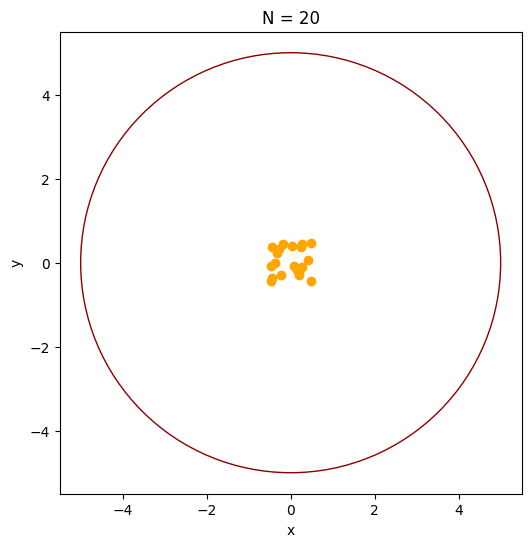

In [5]:
N = 20
R = 5

# generate random initial coordinates of the N charges:
xy = np.random.uniform(-R / 10.0, R / 10.0, (N, 2))

problem = ChargesProblem(xy, R)
problem.add_objective(MinPotential(problem))
problem.add_constraint(MaxRadius(problem))
problem.initialize()

fig = problem.get_fig(xy)
plt.show()

Finally, we can now setup the genetic algorithm [GA from pymoo](https://pymoo.org/algorithms/soo/ga.html) and solve the problem, here in vectorized form (flag `vectorize=True`):

In [6]:
solver = Optimizer_pymoo(
    problem,
    problem_pars=dict(
        vectorize=True,
    ),
    algo_pars=dict(
        type="GA",
        pop_size=100, 
        seed=1,
    ),
    setup_pars=dict(),
    term_pars=dict(
        type="default",
        n_max_gen=300,
        ftol=1e-6,
        xtol=1e-6,
    ),
)
solver.initialize()
solver.print_info()

results = solver.solve(verbosity=0)
solver.finalize(results)

Loading pymoo
pymoo successfully loaded
Initializing Optimizer_pymoo
Selecting sampling: float_random (FloatRandomSampling)
Selecting algorithm: GA (GA)
Selecting termination: default (DefaultSingleObjectiveTermination)

Problem:
--------
  vectorize: True

Algorithm:
----------
  type: GA
  pop_size: 100
  seed: 1

Termination:
------------
  n_max_gen: 300
  ftol: 1e-06
  xtol: 1e-06





Optimizer_pymoo: Optimization run finished
  Success: True
  Best potential = 78.69922244245727


Results problem 'charges_problem':
-----------------------------------
  Float variables:
    0: x0  = 2.236112e+00
    1: y0  = -4.470885e+00
    2: x1  = 2.082072e+00
    3: y1  = 7.199634e-01
    4: x2  = 4.258628e+00
    5: y2  = 2.615461e+00
    6: x3  = 4.931458e+00
    7: y3  = 8.239395e-01
    8: x4  = -3.453717e+00
    9: y4  = -3.615375e+00
    10: x5  = -2.459065e+00
    11: y5  = 4.351725e+00
    12: x6  = -6.527966e-01
    13: y6  = 2.161302e+00
    14: x7  = 1.670812e+00
    15: y7  = -2.382281e+00
    16: x8  = -1.235636e+00
    17: y8  = -1.913568e+00
    18: x9  = -2.099603e+00
    19: y9  = -4.536876e+00
    20: x10 = -4.701957e+00
    21: y10 = -1.697765e+00
    22: x11 = 1.517358e+00
    23: y11 = 4.762982e+00
    24: x12 = 4.845131e+00
    25: y12 = -1.233574e+00
    26: x13 = 4.140025e+00
    27: y13 = -2.796535e+00
    28: x14 = 2.992287e+00
    29: y14 = 4.004978e+00
    30: x15 = 2.484520e-02
    31: y15 = -4.999799e+00
    32: x16 = -4.887334e+00
    33: y16 =

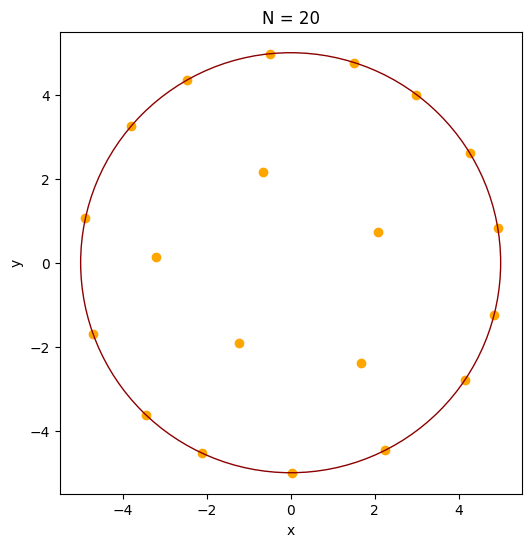

In [7]:
print(results)

xy = results.problem_results
fig = problem.get_fig(xy)
plt.show()

Note that this problem has many equivalent solutions, and the displayed result is the best solution that the genetic algorithm was able to find within its convergence criteria. With heuristic methods there is generally no guarantee or proof that a global optimum has been found. However, the objective function has clearly been minimized, and therefore the "design" was improved which is often the goal in engineering tasks.

For the fun of it, let's also solve the problem using iwopy's `GG` solver (stands for _Greedy Gradient_), now for 50 charges. This solver is a simple steepest decent algorithm which projects out directions that would violate constraints (and reverts those that already do). It supports iwopy's vectorization capabilities and hence can run fast for many variables. Of course it is not as advanced as other gradient based solvers, but for this particular problem it does a good job:

In [8]:
from iwopy import LocalFD
from iwopy.optimizers import GG

In [9]:
N = 50
R = 5

xy = np.random.uniform(-R / 10.0, R / 10.0, (N, 2))

problem = ChargesProblem(xy, R)
problem.add_objective(MinPotential(problem))
problem.add_constraint(MaxRadius(problem))

gproblem = LocalFD(problem, deltas=1e-2, fd_order=1)
gproblem.initialize()

solver = GG(
    gproblem,
    step_max=0.1,
    step_min=1e-4,
    vectorized=True,
)
solver.initialize()

results = solver.solve(verbosity=0)
solver.finalize(results)
print(results)

Problem 'charges_problem' (ChargesProblem): Initializing
--------------------------------------------------------
  n_vars_int  : 0
  n_vars_float: 100
--------------------------------------------------------
  n_objectives: 1
  n_obj_cmptns: 1
--------------------------------------------------------
  n_constraints: 1
  n_con_cmptns: 50
--------------------------------------------------------
Problem 'charges_problem_fd' (LocalFD): Initializing
----------------------------------------------------
  n_vars_int  : 0
  n_vars_float: 100
----------------------------------------------------
  n_objectives: 1
  n_obj_cmptns: 1
----------------------------------------------------
  n_constraints: 1
  n_con_cmptns: 50
----------------------------------------------------


GG: Optimization run finished
  Success: True
  Best potential = 585.5754719667092
Results problem 'charges_problem_fd':
--------------------------------------
  Float variables:
    0: x0  = 1.087311e-01
    1: y0  = 3.652947e+00
    2: x1  = -4.606218e+00
    3: y1  = 1.944930e+00
    4: x2  = -1.887607e+00
    5: y2  = -4.630003e+00
    6: x3  = 3.562191e+00
    7: y3  = 4.047046e-01
    8: x4  = 1.485097e+00
    9: y4  = 1.052208e+00
    10: x5  = 3.858055e+00
    11: y5  = 3.180473e+00
    12: x6  = -4.141494e+00
    13: y6  = -2.801432e+00
    14: x7  = -4.122978e+00
    15: y7  = 2.828613e+00
    16: x8  = -8.834537e-01
    17: y8  = -3.429528e+00
    18: x9  = 2.007586e+00
    19: y9  = -4.579257e+00
    20: x10 = -3.463435e+00
    21: y10 = 3.606192e+00
    22: x11 = 1.932276e-01
    23: y11 = -1.712766e+00
    24: x12 = -1.579416e+00
    25: y12 = 3.213613e+00
    26: x13 = 1.743332e+00
    27: y13 = 3.151292e+00
    28: x14 = -1.420385e+00
    29: y14 = -9.827574e-01
    30:

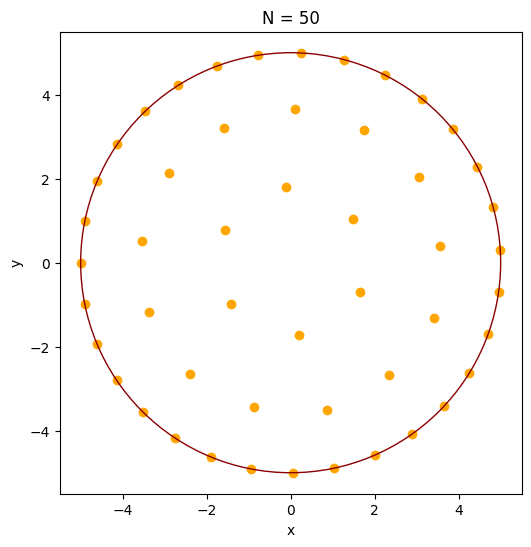

In [10]:
xy = results.problem_results
fig = problem.get_fig(xy)
plt.show()